# Data mining on churn dataset

In this section we'll cover the proper machine learning methods in order to build a model both accurate and able to generalise to new data. This part is in fact further divided in
* a partitioning phase, in which the data is splitted in two subsets, called training and validation set, 
* a training phase, in which the models we choose to use are adapted to the training data,
* and an assessment phase, in which the models are compared to get the model which is more stable to alterations in data

Let's first import the data we processed in the previous section and take a look at it:

In [1]:
churn <- read.table('datasets/churn_working_clean.csv', header=T, sep = ',')

In [2]:
#info
str(churn)

'data.frame':	2333 obs. of  8 variables:
 $ X             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Int.l.Plan    : Factor w/ 2 levels "False","True": 1 1 1 1 1 1 1 1 1 2 ...
 $ VMail.Plan    : Factor w/ 2 levels "False","True": 1 1 2 1 1 1 1 1 2 1 ...
 $ Day.Mins      : num  131 185 176 132 200 ...
 $ Intl.Mins     : num  15.6 14.1 8.6 10.7 11.3 12.2 11.9 6.9 11.8 13.8 ...
 $ Intl.Calls    : int  3 3 3 3 7 2 6 5 5 2 ...
 $ CustServ.Calls: int  3 3 2 1 1 1 1 2 1 1 ...
 $ Churn         : Factor w/ 2 levels "False","True": 1 1 1 1 1 1 1 1 1 2 ...


In [3]:
#head
churn[1:5,]

X,Int.l.Plan,VMail.Plan,Day.Mins,Intl.Mins,Intl.Calls,CustServ.Calls,Churn
0,False,False,130.6,15.6,3,3,False
1,False,False,185.0,14.1,3,3,False
2,False,True,175.7,8.6,3,2,False
3,False,False,131.7,10.7,3,1,False
4,False,False,199.9,11.3,7,1,False


We can eliminate the first column, which is just an index:

In [4]:
churn = subset(churn, select = -1 )
churn[1:5,]

Int.l.Plan,VMail.Plan,Day.Mins,Intl.Mins,Intl.Calls,CustServ.Calls,Churn
False,False,130.6,15.6,3,3,False
False,False,185.0,14.1,3,3,False
False,True,175.7,8.6,3,2,False
False,False,131.7,10.7,3,1,False
False,False,199.9,11.3,7,1,False


## Partitioning

In order to compare the adaptation to the data we can compare metrics on the examples used for training, but if we want to compare generalization, we need new data. 
The best model will be determined by a trade-off between the error functions measured on these different sets of data.

If we don't have already two datasets, we can partition the datasets in order to get two different subsets. The dataset used to train the algorithm is usually called training set, while the one used for the assessment phase which compare the generalization of the models, is usually called validation set.

Many partitioning methods are possible; in this case we opt for an _holdout validation_, which simply generates two datasets from the original one, assigning to each one a different proportion. We decide to set the ratio to 70:30 which is pretty reasonable in case of few data, as in the current scenario.

A better decision would be a _k-fold_ cross-validation, particularely useful in case we are really short of training data, which we may implement later.

In [5]:
set.seed(99)
splitSample <- sample(3, size=nrow(churn), prob=c(0.6,0.2,0.2), replace = TRUE)
churn_train = data.frame(churn[splitSample==1,])
churn_valid = data.frame(churn[splitSample==2,])
churn_test  = data.frame(churn[splitSample==3,])

## Model Training

The problem we are considering is a supervised classification problem. Many models can be adopted to classify a target, but in our study we will limit ourselves to the following models:

* Logistic Regression
* Decision Tree
* Boosted Tree
* Random Forest

Each model will be briefly described when trained. Note that in a binary classification problem we have to specify the event we are referring to in the costruction and evaluation of the models: here all the models will refer to the event 'Churn = yes'.

### Logistic regression

Given the predicted target $\hat{y}$, the parameters vector $\theta$ and the equation that describes the model $h_{\theta}(x)$, called model hypothesis, [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) can be described by the following equation:

$\hat{y} = h_{\theta}(x) = \text{sigmoid} \left( f(x) \right)$

where _sigmoid_ is a function defined as $\text{sigmoid} (z)=\frac{1}{1+e^{-z}}$ and $f(x)$ indicates any function of the features $x$, usually a linear function $\theta^T x$.
This formulation is also equivalent to $\text{logit}(h_\theta(x)) = f(x)$, where _logit_ is a function defined as $\text{logit}(z) = \ln \left( \frac{z}{1-z} \right)$.

In R, we make use of the [glm](https://cran.r-project.org/package=glm2) package, to fit the linear combination of the features to the logit of the target:

In [6]:
model.lr <- glm(Churn ~ ., data=churn_train, family=binomial(link='logit'))
#print(model.lr)
summary(model.lr)


Call:
glm(formula = Churn ~ ., family = binomial(link = "logit"), data = churn_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9416  -0.5220  -0.3505  -0.2195   2.9449  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -6.292252   0.560756 -11.221  < 2e-16 ***
Int.l.PlanTrue  2.023198   0.219168   9.231  < 2e-16 ***
VMail.PlanTrue -0.622797   0.203285  -3.064  0.00219 ** 
Day.Mins        0.014938   0.001671   8.942  < 2e-16 ***
Intl.Mins       0.083575   0.031049   2.692  0.00711 ** 
Intl.Calls     -0.062646   0.036700  -1.707  0.08783 .  
CustServ.Calls  0.489885   0.059825   8.189 2.64e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1163.82  on 1403  degrees of freedom
Residual deviance:  935.02  on 1397  degrees of freedom
AIC: 949.02

Number of Fisher Scoring iterations: 5


### Decision Tree


A [decision tree](https://en.wikipedia.org/wiki/Decision_tree) is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statemens.

The dataset is segmented in mutually exclusive groups, called nodes, internally homogeneous and heterogeneous between them with respect to the target variable. A split criterion is defined to determine the ramification and pruning rules are set to subsequently thin the tree. The predicted target is assigned to the most frequent class in a terminal node (or leaf). 

Many algorithms can be used to build a decision tree, each one using different split types, split criteria, and suited for different input features and targets.

Here we want to use CART algorithm[1], setting very weak pre-pruning rules and applying subsequently post-pruning on validation data. Precisely:
* Split: max impurity deacrease w/ gini index (CART)
* Pre-pruning: min numerosity = 2
* Post-pruning: cost complexity pruning

To build the model in R we make use of the libraries [rpart](https://cran.r-project.org/web/packages/rpart/index.html) and [rpart.plot](https://cran.r-project.org/web/packages/rpart.plot/index.html):

In [7]:
#install.packages("rpart")
#install.packages("rpart.plot")
library("rpart")
library("rpart.plot")

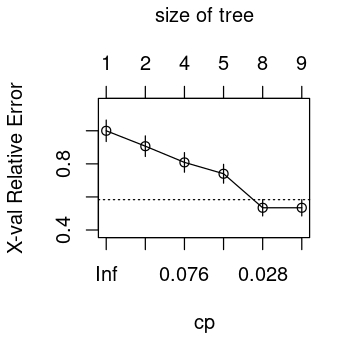

In [8]:
# Training w/ pre-pruning
model.tree = rpart(Churn ~ ., data=churn_train, method="class", minsplit=2, parms=list(split="gini"))
options(repr.plot.width=3, repr.plot.height=3)
plotcp(model.tree)

We note that the complexity parameter cp doesn't decrease with the last split. Applying a cost complexity-based pruning, setting the minimum cp to reduce at 0.03 we get a thinner tree:

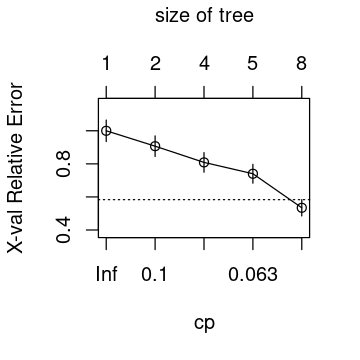

In [9]:
# Post-pruning
model.tree = prune(model.tree, cp = 0.03, data=churn_valid)
plotcp(model.tree)

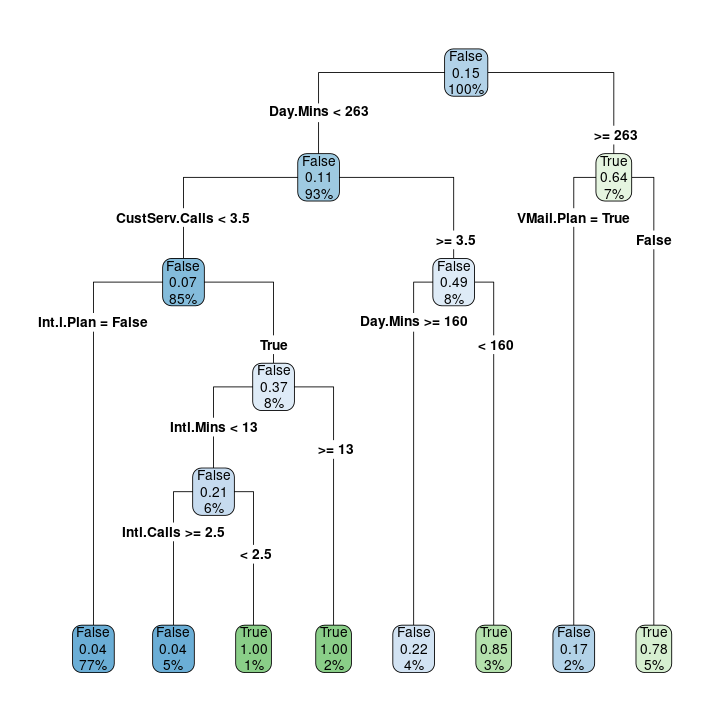

In [10]:
options(repr.plot.width=6, repr.plot.height=6)
rpart.plot(model.tree, type=4, tweak=1)

In [11]:
summary(model.tree)

Call:
rpart(formula = Churn ~ ., data = churn_train, method = "class", 
    parms = list(split = "gini"), minsplit = 2)
  n= 1404 

          CP nsplit rel error    xerror       xstd
1 0.13235294      0 1.0000000 1.0000000 0.06472797
2 0.07843137      1 0.8676471 0.9068627 0.06212609
3 0.07352941      3 0.7107843 0.8088235 0.05915125
4 0.05392157      4 0.6372549 0.7401961 0.05690498
5 0.03000000      7 0.4509804 0.5343137 0.04915123

Variable importance
      Day.Mins CustServ.Calls     Intl.Calls      Intl.Mins     Int.l.Plan 
            39             18             14             11             11 
    VMail.Plan 
             7 

Node number 1: 1404 observations,    complexity param=0.1323529
  predicted class=False  expected loss=0.1452991  P(node) =1
    class counts:  1200   204
   probabilities: 0.855 0.145 
  left son=2 (1305 obs) right son=3 (99 obs)
  Primary splits:
      Day.Mins       < 263.1  to the left,  improve=51.368730, (0 missing)
      CustServ.Calls < 3.5    to

## Boosted Tree

Boosted tree is an ensemble method (boosting) applied to the decision tree models. [Ensemble methods](https://en.wikipedia.org/wiki/Ensemble_learning) use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. They are more accurate and more robust than their single counterparts.

When _boosting_ the ensemble model evolves from the starting models by readapting the single models at each iteration, posing attention to misclassified events. 

![boosting](media/boosting.png)

One of the most widespread boosting algorithms and in general one of the most appreciated[2] data mining algorithms is AdaBoost[3].

Here we apply the AdaBoost algorithm from the [gbm](https://cran.r-project.org/web/packages/gbm/index.html) package, setting an high number of iterations (500):

In [12]:
#install.packages("gbm")
library("gbm")

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


In [13]:
model.btree = gbm(Churn ~ ., data=churn_train, distribution = "multinomial", n.trees = 500)
print(model.btree)
#summary(model.btree)

gbm(formula = Churn ~ ., distribution = "multinomial", data = churn_train, 
    n.trees = 500)
A gradient boosted model with multinomial loss function.
500 iterations were performed.
There were 6 predictors of which 3 had non-zero influence.


## Random Forest

[Random forests](https://en.wikipedia.org/wiki/Random_forest) create an ensemble of decision trees using [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) samples of the training set. 

Moreover, when building each tree and at every single split a random sample of $p$ features is chosen as a split candidate from the full set of $n$ features (usually $p=\sqrt{n}$ in classification problems). 
This allows to overcome the problem of high correlation of bagged trees. When not using a random subset of features as in bagged trees, most of the trees will use the same feature as the top split, resulting in an ensemble of similar trees that are highly correlated.

As final prediction the most frequent prediction in the single models is considered.

![random_forest](media/random_forest.png)

The [randomForest](https://cran.r-project.org/web/packages/randomForest/index.html) library allow us to apply random forests algorithms in R. Given the scarcity of data, we set a high number of bootstrap samples (500), while we fix to 3 the number of variables in each random sample of features.

In [14]:
#install.packages("randomForest")
library("randomForest")

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [15]:
model.rforest = randomForest(Churn ~ ., data=churn_train, ntree=500, nodesize=3)
print(model.rforest)
summary(model.rforest)


Call:
 randomForest(formula = Churn ~ ., data = churn_train, ntree = 500,      nodesize = 3) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 7.91%
Confusion matrix:
      False True class.error
False  1165   35  0.02916667
True     76  128  0.37254902


                Length Class  Mode     
call               5   -none- call     
type               1   -none- character
predicted       1404   factor numeric  
err.rate        1500   -none- numeric  
confusion          6   -none- numeric  
votes           2808   matrix numeric  
oob.times       1404   -none- numeric  
classes            2   -none- character
importance         6   -none- numeric  
importanceSD       0   -none- NULL     
localImportance    0   -none- NULL     
proximity          0   -none- NULL     
ntree              1   -none- numeric  
mtry               1   -none- numeric  
forest            14   -none- list     
y               1404   factor numeric  
test               0   -none- NULL     
inbag              0   -none- NULL     
terms              3   terms  call     

# Assessment

In the previous phase we trained our models, so that they would fit the training data. In this phase we want to compare them using new data in order to find the most _robust_ model. 

Backed by stochastic interpretation of probability, we have associated a probability to the classes of each example. Usually classification is made by assigning the target to the class with highest probability, but this is not always the case, as sometimes different errors may have different costs. This results typically in a different threshold probability used to choose the class of the target.

By considering the probabilities instead of the target labels, the following techiniques allow us to compare the models regardless of the threshold and to see which one best fits a variety of situations. 

First, let's import the required [ROCR](https://cran.r-project.org/web/packages/ROCR/index.html) library and declare the objects:

In [16]:
#install.packages("ROCR")
library("ROCR")

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [17]:
lr=list()
tree=list()
btree=list()
rforest=list()

In [18]:
# Logistic regression
lr$prob <- predict(model.lr, newdata=churn_valid, type="response")
lr$pred <- prediction(lr$prob, churn_valid$'Churn')
# Tree
tree$prob <- predict(model.tree, newdata=churn_valid, type="prob")
tree$pred <- prediction(tree$prob[,2], churn_valid$'Churn')
# Boosted tree
btree$prob <- predict(model.btree, newdata=churn_valid, n.trees=500, type="response")
btree$pred <- prediction(btree$prob[,2,], churn_valid$'Churn')
# Random Forest
rforest$prob <- predict(model.rforest, newdata=churn_valid, type="prob")
rforest$pred <- prediction(rforest$prob[,2], as.integer(churn_valid$'Churn')-1)

### ROC Curves

In a ROC (Receiver Operating Characteristic) curve we have [FPR](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) on the $x$ axis and [TPR](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) on the $y$ axis. The ROC Curve allows the modeler to look at the performance of his model across all possible thresholds.
A synthetic measure is given by the Area Under Curve(AUC), which is maximized by a good model and should be at least greater than 0.5, otherwise a random classifier would be better than our model.

First we create the objects containing the measures: 

In [19]:
# Logistic regression
lr$roc <- performance(lr$pred, measure = "tpr", x.measure = "fpr")
lr$auc <- performance(lr$pred, measure = "auc")@y.values[[1]]
lr$roc_df <- data.frame(fpr=unlist(lr$roc@x.values),tpr=unlist(lr$roc@y.values))
# Tree
tree$roc <- performance(tree$pred, measure = "tpr", x.measure = "fpr")
tree$auc <- performance(tree$pred, measure = "auc")@y.values[[1]]
tree$roc_df <- data.frame(fpr=unlist(tree$roc@x.values),tpr=unlist(tree$roc@y.values))
# Boosted Tree
btree$roc <- performance(btree$pred, measure = "tpr", x.measure = "fpr")
btree$auc <- performance(btree$pred, measure = "auc")@y.values[[1]]
btree$roc_df <- data.frame(fpr=unlist(btree$roc@x.values),tpr=unlist(btree$roc@y.values))
# Random Forest
rforest$roc <- performance(rforest$pred, measure = "tpr", x.measure = "fpr")
rforest$auc <- performance(rforest$pred, measure = "auc")@y.values[[1]]
rforest$roc_df <- data.frame(fpr=unlist(rforest$roc@x.values),tpr=unlist(rforest$roc@y.values))

Then we visualize them in ROC curves:

In [20]:
#install.packages("ggplot2")
library("ggplot2")


Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



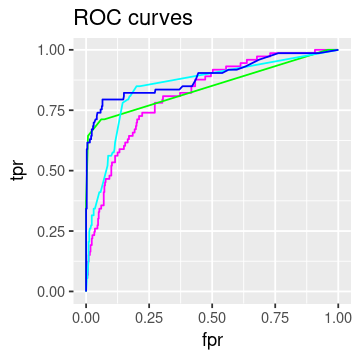

In [21]:
options(repr.plot.width=3, repr.plot.height=3)
ggplot(data=lr$roc_df, aes(x=fpr, ymin=0, ymax=0)) +
    geom_ribbon(alpha=0.2) +
    geom_line(data=lr$roc_df, aes(y=tpr), color = 'magenta') + 
    geom_line(data=tree$roc_df, aes(y=tpr), color = 'green') + 
    geom_line(data=btree$roc_df, aes(y=tpr), color = 'cyan') + 
    geom_line(data=rforest$roc_df, aes(y=tpr), color = 'blue') +
    ggtitle("ROC curves")

In [22]:
cat("Areas under ROC curves\n")
cat("Logistic regression:\t", lr$auc)
cat("\nTree:\t\t\t", tree$auc)
cat("\nBoosted tree:\t\t", btree$auc)
cat("\nRandom forest:\t\t", rforest$auc)

Areas under ROC curves
Logistic regression:	 0.817911
Tree:			 0.8485103
Boosted tree:		 0.8506336
Random forest:		 0.888476

From the graph we can see the better trend, confirmed by the AUC, of the ensemble methods (boosted tree and random forest) which can count on bootstrap methods in order to overcome the small numerosity of the dataset. The decision tree seems also a good choice, but its ROC curve is made of few points and is not so reliable.

## Lift charts

Although Random Forest's AUC is the greatest, we may want to consider another assessment method to be sure to pick the best model, so we analyze the [lift charts](https://en.wikipedia.org/wiki/Lift_(data_mining)) for our models.

To get the lift chart of a model, we first order the predictions by class probability and we split them in subgroups (quartiles, deciles, ...). Then we calculate:
* Captured Response = #successes in subgroup / #successes
* Lift = Captured Response / Global Probability of success

A good model will capture the response before the others i.e. it will have higher captured responses and lifts in the first quantiles.

In [23]:
# Logistic regression
lr$lift <- performance(lr$pred, measure = "lift",x.measure = "rpp")
lr$lift_df <- data.frame(quantile=unlist(lr$lift@x.values)[-1],lift=unlist(lr$lift@y.values)[-1])
# Tree
tree$lift <- performance(tree$pred, measure = "lift",x.measure = "rpp")
tree$lift_df <- data.frame(quantile=unlist(tree$lift@x.values)[-1],lift=unlist(tree$lift@y.values)[-1])
# Boosted Tree
btree$lift <- performance(btree$pred, measure = "lift",x.measure = "rpp")
btree$lift_df <- data.frame(quantile=unlist(btree$lift@x.values)[-1],lift=unlist(btree$lift@y.values)[-1])
# Random Forest
rforest$lift <- performance(rforest$pred, measure = "lift",x.measure = "rpp")
rforest$lift_df <- data.frame(quantile=unlist(rforest$lift@x.values)[-1],lift=unlist(rforest$lift@y.values)[-1])

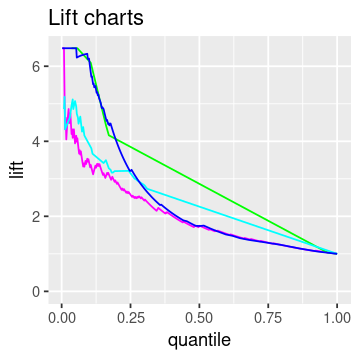

In [24]:
options(repr.plot.width=3, repr.plot.height=3)
ggplot(data=lr$lift_df, aes(x=quantile, ymin=0, ymax=0)) +
    geom_ribbon(alpha=0.2) +
    geom_line(data=lr$lift_df, aes(y=lift), color = 'magenta') + 
    geom_line(data=tree$lift_df, aes(y=lift), color = 'green') + 
    geom_line(data=btree$lift_df, aes(y=lift), color = 'cyan') + 
    geom_line(data=rforest$lift_df, aes(y=lift), color = 'blue') +
    ggtitle("Lift charts")

As we can see, the Random Forest model captures the response before the Boosted Tree.  

## Conclusions

In the light of the previous considerations, we end up choosing the Random Forest model as the most robust. In the next section we will evaluate this model on a new dataset (test set) in order to have an unbiased measure of its performance and we will set a new threshold based on the costs associated to the different errors in the confusion matrix. 

---
__References__
* [1]L. Breiman, Ed., Classification and regression trees, Repr. Boca Raton: Chapman & Hall [u.a.], 1998.
* [2]X. Wu et al., “Top 10 algorithms in data mining,” Knowledge and Information Systems, vol. 14, no. 1, pp. 1–37, Jan. 2008.
* [3]Y. Freund, R. E. Schapire, and others, “Experiments with a new boosting algorithm,” in Icml, 1996, vol. 96, pp. 148–156.